In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [2]:
'''
Creating an atlas
'''

deep_reload(nice)

rng = np.random.default_rng(26893751)

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
    'create_using': nx.DiGraph
}

atlas = nice.graph.nmu_graph(100, 3, **kw)

for source, _adj in atlas._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']
        edge['consumption'] = 500 * edge['distance']
        edge['cost'] = edge['time']

In [3]:
atlas.__class__

networkx.classes.digraph.DiGraph

In [4]:
'''
Selecting places and stations
'''
deep_reload(nice)

n_places = 15
n_stations = 45

rng = np.random.default_rng(26589763514)

places = list(rng.choice(atlas.nodes, replace = False, size = n_places))
stations = list(rng.choice(
    list(set(atlas.nodes) - set(places)), replace = False, size = n_stations
))

In [5]:
'''
Transforming Graph
'''
deep_reload(nice)

conditions = [
    lambda e: e['distance'] <= 400e3,
    lambda e: e['distance'] >= 100e3,
]

kw = {
    'fields': ['time', 'distance']
}

nodes = places + stations

graph = nice.optimization.transformed_graph(atlas, nodes, conditions, **kw)

In [7]:
paths = nice.optimization.get_paths(
    graph, terminals = places, k = 10, weight = 'time',
)

In [181]:
'''
Adding classes
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

for place in places:

    destinations = set(places) - set([place])
    demands = rng.uniform(0, 1, size = len(destinations))
    demands /= demands.sum()

    graph._node[place]['penalty'] = {}
    
    path = nx.shortest_path(graph, source = place, weight = 'ac_time')
    
    for destination in destinations:

        costs = nice.graph.path_cost(
            graph, path[destination], fields = ['time']
        )
        
        graph._node[place]['penalty'][destination] = costs['time'] * 200
    
    graph._node[place]['flows'] = {p: demands[i] for i, p in enumerate(destinations)}
    graph._node[place]['_class'] = nice.optimization.Place

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))
c = np.arange(0, 51, 5)
# c = [1, 2]

queue = nice.queue.Queue(m = m)
volumes = np.array([rho * m * size for size in c])
delays =  np.array([queue.interpolate(rho, size) * rho * m * size for size in c])

for station in stations:

    graph._node[station]['power'] = 80e3
    graph._node[station]['_class'] = nice.optimization.Station

    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes)
    graph._node[station]['expenditures'] = c

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = nice.optimization.Edge

for path in paths:

    path['capacity'] = 80 * 3.6e6 / 2
    path['_class'] = nice.optimization.Path

In [182]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Sets Built: 0.008221149444580078
Parameters Built: 0.0368349552154541
Variables Built: 0.23253726959228516
Constraints Built: 0.790114164352417
Expenditure Built: 0.0013937950134277344
Objective Built: 0.011761903762817383


In [197]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        # '_name': 'cbc',
        '_name': 'appsi_highs',
    },
}

network.model.scale = 10 / 3600
network.model.expenditure = 100
network.solve(**kw)
# solution = network.solution
solution = nice.optimization.solution_atlas(network.solution, atlas, fields = ['volume'])

Problem Solved: 78.87030601501465
Results Collected: 0.03152060508728027


In [198]:
import pyomo.environ as pe

pe.value(network.model.objective)

49844.077490323296

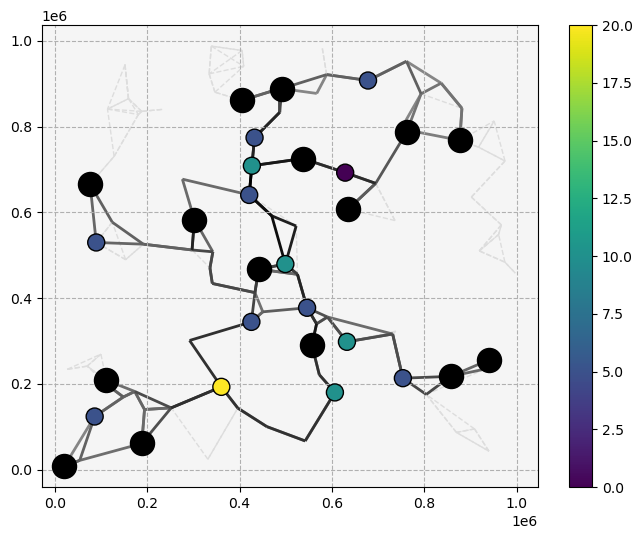

In [199]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

eps = 0

selection = (
    [(s, t) for s, a in solution._adj.items() \
     for t, e in a.items() if e.get('volume', 0) > eps]
)

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600

kw = {
    'nodes': {
        # 'field': 'volume_h',
        'field': 'selection',
        'cmap': nice.plot.Colormap(),
        'selection': [k for k, n in solution._node.items() if n.get('volume', 0) > 0],
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
        },
        'colorbar': {
            # 'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'volume',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 300,
            'fc': 'k',
            'ec': 'k',
            'zorder': 2,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [147]:
# {k: v['selection'] for k, v in solution._node.items() if 'size' in v}

In [167]:
{k: v for k, v in solution._node.items() if 'penalty' in v}

{4: {'object': <nice.optimization.place.Place at 0x7f11576ba420>,
  'x': 761547.665712458,
  'y': 786386.4267076738,
  'cost': 43814.7817065978,
  'penalty': {33: 13716214.294977672,
   36: 11584621.358291462,
   39: 993528.7954789754,
   10: 6739309.007677335,
   78: 10838497.91048817,
   81: 9087027.212284328,
   19: 3200564.9355096174,
   61: 13598577.622590011,
   55: 11632337.511999033,
   56: 5356414.624643587,
   58: 15639482.19091664,
   27: 3826740.641078045,
   92: 7097137.966785544,
   29: 7775139.061523027},
  'flows': {33: 0.07017670299797613,
   36: 0.12505923048660603,
   39: 0.01374604989685802,
   10: 0.04529862470792129,
   78: 0.04143869069705348,
   81: 0.1094003464274585,
   19: 0.10130630647129335,
   61: 0.05933155387653526,
   55: 0.13545119852122148,
   56: 0.032887175261675526,
   58: 0.004498519112536572,
   27: 0.1393802109883091,
   92: 0.00013847205450416564,
   29: 0.12188691850005114},
  '33:direct': 0.19493528610548924,
  '36:direct': 0.3473867513516834